## 3f. Explainable Artificial Intelligence (XAI) - Shapley Additive Explanation (SHAP) using KernelSHAP for MLPClassifier - Explainer Evaluation

### Load Data and the Saved Model

In [1]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
from matplotlib import pyplot as plt

df = pd.read_csv("../preprocessed/clean_survey.csv", index_col=False)
# split to indenpendent and dependent variables
# drop all variables computing the labels
X = df.drop(['q_031_adjusted', 'invol_score', 'q_031', 'involvement_level'] + [f'q_0{i}' for i in range(45, 55)], axis=1)
y = df["involvement_level"]

# Encode the class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and test sets
X_train, X_test, y_encoded_train, y_encoded_test = train_test_split(X, y_encoded, stratify=y_encoded, random_state=42)

# Data Preprocessing
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Store in dataframe for plotting
feature_names = X_train.columns.tolist()
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
print(label_mapping)

{0: 'High', 1: 'Low', 2: 'Medium'}


In [2]:
print("Shape of X_train_scaled:", X_train_scaled.shape)  # Should be (num_samples, num_features)
print("Shape of y_encoded_train:", y_encoded_train.shape)  # Should be (num_samples,)

Shape of X_train_scaled: (656, 91)
Shape of y_encoded_train: (656,)


In [3]:
import pickle
# fit the best model
# Load the model from a file
with open('../models/neural_1.pkl', 'rb') as file:
    model1 = pickle.load(file)

In [4]:
# Making predictions
y_pred1 = model1.predict(X_test_scaled)

accuracy1 = accuracy_score(y_encoded_test, y_pred1)
print("Testing Subset Accuracy: ", accuracy1)
print("Hamming Loss:", hamming_loss(y_encoded_test, y_pred1))

# Micro-average
print("F1 Score (Micro):", f1_score(y_encoded_test, y_pred1, average='micro'))
# Macro-average
print("F1 Score (Macro):", f1_score(y_encoded_test, y_pred1, average='macro'))
# Weighted-average
print("F1 Score (Weighted):", f1_score(y_encoded_test, y_pred1, average='weighted'))

# ROC-AUC
# Note: roc_auc_score expects a shape of (n_samples,) for binary problems and
# (n_samples, n_classes) for multi-class/multi-label with one-hot encoding.
# ROC-AUC calculation needs probabilistic predictions `y_proba`
# use macro since class labels are imbalanced
y_proba = model1.predict_proba(X_test_scaled)
roc_auc = roc_auc_score(y_encoded_test, y_proba, average='macro', multi_class='ovr')
print("ROC-AUC (Macro):", roc_auc)

Testing Subset Accuracy:  0.6621004566210046
Hamming Loss: 0.3378995433789954
F1 Score (Micro): 0.6621004566210046
F1 Score (Macro): 0.6145972407654651
F1 Score (Weighted): 0.6598569782541105
ROC-AUC (Macro): 0.7403684201784498


### 3.1 Compute Shapley Values (Using saved output)

In [5]:
import shap
import pickle
shap.initjs()
# Make sure the input data is in the correct format (e.g., a NumPy array)

shap_explainer = shap.KernelExplainer(model1.predict_proba, X_train_scaled)
with open('../shaps/shap_values_kernel.pkl', 'rb') as file:
    shap_values = pickle.load(file)
# shap_values_scaled = shap_explainer.shap_values(X_test_scaled)

Using 656 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [6]:
shap_values

[array([[ 0.00090369, -0.00105285, -0.00104333, ...,  0.00033032,
          0.        , -0.00842827],
        [-0.00411343,  0.00034846, -0.00040389, ..., -0.00046197,
         -0.0028824 ,  0.        ],
        [-0.0002826 ,  0.00150608, -0.00045323, ..., -0.00030342,
          0.00073908,  0.00111605],
        ...,
        [ 0.00420085,  0.00429707,  0.01316575, ...,  0.        ,
         -0.01350586,  0.01756766],
        [-0.00082586,  0.00033351, -0.00533674, ...,  0.00033123,
          0.00252991,  0.00046329],
        [-0.00072511,  0.        ,  0.00545065, ..., -0.00272313,
         -0.00540213,  0.0035548 ]]),
 array([[-0.01071235, -0.02780975, -0.03980878, ..., -0.0093679 ,
          0.01016535,  0.00542642],
        [ 0.11804064,  0.00261079, -0.05034489, ..., -0.00322974,
         -0.05000902, -0.00281714],
        [-0.01708959, -0.01131108, -0.00646892, ...,  0.00464388,
          0.00975737,  0.        ],
        ...,
        [-0.0287443 , -0.0161447 ,  0.0314138 , ...,  

In [7]:
# Retrieve feature names after dropping columns
feature_names = X.columns.tolist()

### 3.3 SHAP Feature Importance Plot
This plot shows the most important features that influence the model's predictions. Green is class 'High', Blue is class 'Low' and Pink is class 'Medium'.

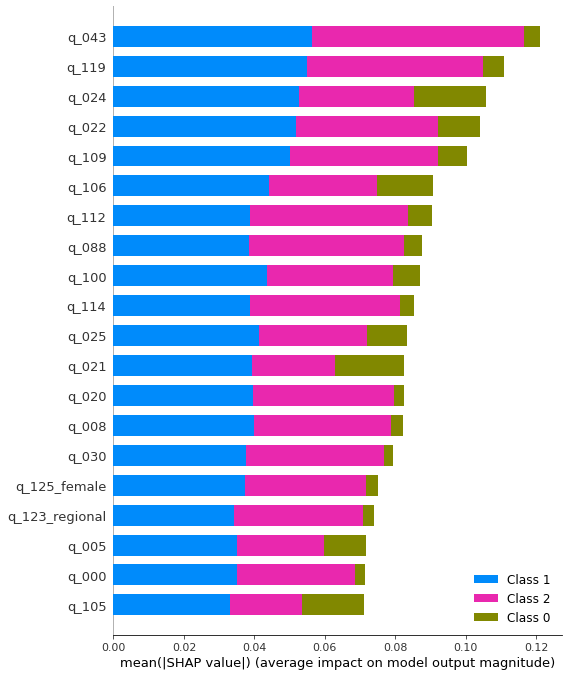

In [8]:
shap.initjs
shap.summary_plot(shap_values, X_test, feature_names=X.columns.tolist())

In [9]:
"""from matplotlib import pyplot as plt
# Aggregate SHAP values across all classes, then compute the mean absolute value for each feature
aggregated_shap = np.sum([np.abs(values) for values in shap_values], axis=0)


mean_abs_shap_values = np.mean(aggregated_shap, axis=0)

# Create a DataFrame for easier manipulation and visualization
df_feature_importances = pd.DataFrame({
    'Feature': X_test.columns,
    'MeanAbsSHAP': mean_abs_shap_values
}).sort_values(by='MeanAbsSHAP', ascending=False)

# Calculate cumulative sum of mean absolute SHAP values
df_feature_importances['CumulativeSum'] = df_feature_importances['MeanAbsSHAP'].cumsum()
df_feature_importances['CumulativePercentage'] = df_feature_importances['CumulativeSum'] / df_feature_importances['MeanAbsSHAP'].sum() * 100

# Plot cumulative percentage of mean absolute SHAP values
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(df_feature_importances) + 1), df_feature_importances['CumulativePercentage'], marker='o')
plt.xlabel('Number of Top Features')
plt.ylabel('Cumulative Percentage of Mean Absolute SHAP Values')
plt.title('Representativeness of Top Features')
plt.grid(True)
plt.xticks(range(1, len(df_feature_importances) + 1, 5))  # Adjust the step size as needed
plt.show()

# Print the number of features required to reach a desired cumulative percentage
threshold = 80
# Find the index where the cumulative percentage exceeds the threshold
threshold_index = np.argmax(df_feature_importances['CumulativePercentage'] >= threshold)
# Select the most representative features based on the threshold
selected_features = df_feature_importances.iloc[:threshold_index + 1]
selected_features.shape"""

"from matplotlib import pyplot as plt\n# Aggregate SHAP values across all classes, then compute the mean absolute value for each feature\naggregated_shap = np.sum([np.abs(values) for values in shap_values], axis=0)\n\n\nmean_abs_shap_values = np.mean(aggregated_shap, axis=0)\n\n# Create a DataFrame for easier manipulation and visualization\ndf_feature_importances = pd.DataFrame({\n    'Feature': X_test.columns,\n    'MeanAbsSHAP': mean_abs_shap_values\n}).sort_values(by='MeanAbsSHAP', ascending=False)\n\n# Calculate cumulative sum of mean absolute SHAP values\ndf_feature_importances['CumulativeSum'] = df_feature_importances['MeanAbsSHAP'].cumsum()\ndf_feature_importances['CumulativePercentage'] = df_feature_importances['CumulativeSum'] / df_feature_importances['MeanAbsSHAP'].sum() * 100\n\n# Plot cumulative percentage of mean absolute SHAP values\nplt.figure(figsize=(10, 6))\nplt.plot(range(1, len(df_feature_importances) + 1), df_feature_importances['CumulativePercentage'], marker='o')

In [10]:
# Aggregate SHAP values across all classes, then compute the mean absolute value for each feature
aggregated_shap = np.sum([np.abs(values) for values in shap_values], axis=0)
mean_abs_shap_values = np.mean(aggregated_shap, axis=0)

mean_abs_shap_values

array([0.07138272, 0.03883021, 0.06867182, 0.04530689, 0.0715989 ,
       0.05088897, 0.03330623, 0.08218989, 0.05087425, 0.04734535,
       0.03661248, 0.03864247, 0.03658046, 0.06887081, 0.0223276 ,
       0.04223692, 0.0427077 , 0.08239672, 0.08248745, 0.10399517,
       0.04155   , 0.10573016, 0.08340743, 0.03758835, 0.03472337,
       0.07941327, 0.02881787, 0.05314983, 0.04673705, 0.0332164 ,
       0.02828995, 0.04385001, 0.02275189, 0.04722342, 0.02785971,
       0.12109912, 0.0307292 , 0.02516444, 0.034752  , 0.03632814,
       0.03046106, 0.03774215, 0.04933456, 0.05480277, 0.02295192,
       0.08768636, 0.0342279 , 0.02240254, 0.02058131, 0.0418996 ,
       0.02731498, 0.03887861, 0.02272221, 0.08690867, 0.04403143,
       0.0354685 , 0.04991299, 0.04114106, 0.0711087 , 0.09059792,
       0.04652223, 0.03433379, 0.1002168 , 0.05291189, 0.04173612,
       0.09052315, 0.02790979, 0.08529393, 0.05016678, 0.0333407 ,
       0.02926548, 0.02364035, 0.11083971, 0.05492861, 0.03376

In [11]:
# Create a DataFrame for easier manipulation and visualization
df_feature_importances = pd.DataFrame({
    'Feature': X_test.columns,
    'MeanAbsSHAP': mean_abs_shap_values
}).sort_values(by='MeanAbsSHAP', ascending=False)

# Calculate cumulative sum of mean absolute SHAP values
df_feature_importances['CumulativeSum'] = df_feature_importances['MeanAbsSHAP'].cumsum()
df_feature_importances['CumulativePercentage'] = df_feature_importances['CumulativeSum'] / df_feature_importances['MeanAbsSHAP'].sum() * 100
df_feature_importances['RateOfChange'] = df_feature_importances['CumulativeSum'].pct_change() * 100
df_feature_importances.head(34)
with open('../shaps/df_feature_contri_kernel.pkl', 'wb') as f:
    pickle.dump(df_feature_importances, f)

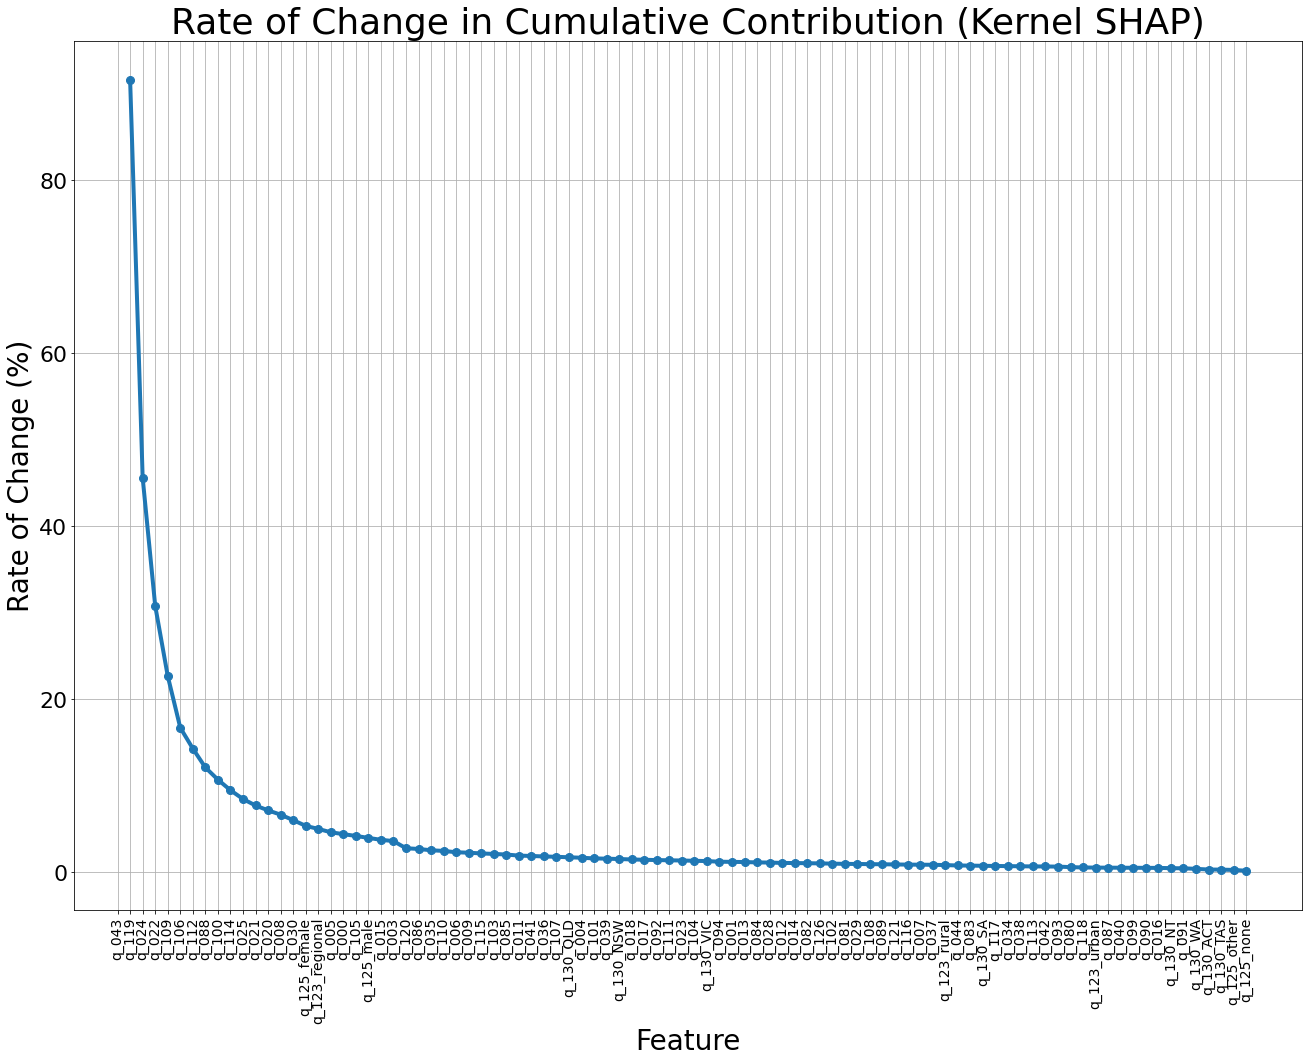

In [12]:
plt.figure(figsize=(22, 16))
plt.plot(df_feature_importances['Feature'], df_feature_importances['RateOfChange'], marker='o', markersize=8, lw=4)
plt.title('Rate of Change in Cumulative Contribution (Kernel SHAP)', fontsize=36)
plt.xlabel('Feature', fontsize=28)
plt.ylabel('Rate of Change (%)', fontsize=28)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=22)
plt.grid(True)
plt.show()

In [13]:
import numpy as np
# Define the staining function
def stain_labels(X, y, feature_indices, target_label):
    y_stained = y.copy()
    stain_indices = np.zeros(len(y), dtype=bool)
    
    for feature_index in feature_indices:
        feature_values = X[:, feature_index]
        stain_indices |= feature_values > feature_values.mean()  # Example complex rule: OR across multiple features
    
    y_stained[stain_indices] = target_label
    return y_stained, stain_indices

# Verify that the model's behavior aligns with the staining function
def verify_stained_model(model, X_test_scaled, original_labels, staining_function, feature_indices):
    predictions = model.predict(X_test_scaled)
    
    feature_values = np.column_stack([X_test_scaled[:, feature_index] for feature_index in feature_indices])
    expected_stain_indices = np.any(feature_values > feature_values.mean(axis=0), axis=1)
    expected_labels = staining_function[expected_stain_indices]
    
    # Compare the model's predictions with the expected staining function's labels
    agreement_stained = np.mean(predictions[expected_stain_indices] == expected_labels)
    agreement_original = np.mean(predictions == original_labels)
    
    print(f"Agreement between model predictions and staining function: {agreement_stained * 100:.2f}%")
    print(f"Agreement between model predictions and original labels: {agreement_original * 100:.2f}%")
    return agreement_stained, agreement_original

# Define a function to calculate recall of important features
def calculate_recall(shap_values, stain_indices, feature_index):
    important_features = np.argmax(np.abs(shap_values), axis=-1)
    stained_important = important_features[stain_indices] == feature_index
    recall = np.mean(stained_important)
    return recall

In [14]:
from sklearn.neural_network import MLPClassifier

# List of features to iterate over
features_to_stain = df_feature_importances[(df_feature_importances['RateOfChange'].isna()) | (df_feature_importances['RateOfChange'] >= 3)]['Feature'].tolist()
target_stain_label = 0  # Example target label (e.g., 'High')

# Convert feature names to indices
feature_indices_to_stain = [feature_names.index(feature) for feature in features_to_stain]

# Initialize list to store recall scores
all_recalls = []

for feature_index in feature_indices_to_stain:
    print(f"Staining and evaluating feature: {feature_names[feature_index]}")
    
    # Create stained labels for training set
    y_stained_train, stain_indices_train = stain_labels(X_train_scaled, y_encoded_train, [feature_index], target_stain_label)
    
    # Create and train the stained model
    model_stained = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)
    model_stained.fit(X_train_scaled, y_stained_train)
    
    # Verify the model
    staining_function = np.full_like(y_encoded_test, target_stain_label)
    agreement_stained, agreement_original = verify_stained_model(model_stained, X_test_scaled, y_encoded_test, staining_function, [feature_index])
    
    # Only proceed if the model passes the validation step for stained labels
    if agreement_stained >= 0.9 and agreement_original < 0.6:  # Ensures model isn't trivially learning the stain
        # Identify stained indices in the test set
        _, stain_indices_test = stain_labels(X_test_scaled, y_encoded_test, [feature_index], target_stain_label)
        
        # Fit the SHAP KernelExplainer
        background = shap.sample(X_train_scaled_df, 100)  # Sample 100 instances for background
        shap_explainer_stained = shap.KernelExplainer(model_stained.predict_proba, background)
        shap_values_stained = shap_explainer_stained.shap_values(X_test_scaled)
        
        # Calculate recall for each class
        recalls = []
        for shap_values_class in shap_values_stained:
            recalls.append(calculate_recall(shap_values_class, stain_indices_test, feature_index))
        
        # Average recall across classes
        average_recall = np.mean(recalls)
        
        # Store the average recall
        all_recalls.append(average_recall)
    else:
        print(f"Model for feature {feature_names[feature_index]} did not pass the validation step.")

# Average recall across all features
if all_recalls:
    final_average_recall = np.mean(all_recalls)
    print("Final Average Recall of Stained Features:", final_average_recall)
else:
    print("No models passed the validation step.")

Staining and evaluating feature: q_043
Agreement between model predictions and staining function: 93.75%
Agreement between model predictions and original labels: 40.18%


  0%|          | 0/219 [00:00<?, ?it/s]

Staining and evaluating feature: q_119
Agreement between model predictions and staining function: 64.03%
Agreement between model predictions and original labels: 37.44%
Model for feature q_119 did not pass the validation step.
Staining and evaluating feature: q_024
Agreement between model predictions and staining function: 95.59%
Agreement between model predictions and original labels: 47.49%


  0%|          | 0/219 [00:00<?, ?it/s]

Staining and evaluating feature: q_022
Agreement between model predictions and staining function: 95.31%
Agreement between model predictions and original labels: 44.29%


  0%|          | 0/219 [00:00<?, ?it/s]

Staining and evaluating feature: q_109
Agreement between model predictions and staining function: 100.00%
Agreement between model predictions and original labels: 47.49%


  0%|          | 0/219 [00:00<?, ?it/s]

Staining and evaluating feature: q_106
Agreement between model predictions and staining function: 98.61%
Agreement between model predictions and original labels: 49.32%


  0%|          | 0/219 [00:00<?, ?it/s]

Staining and evaluating feature: q_112
Agreement between model predictions and staining function: 97.69%
Agreement between model predictions and original labels: 22.83%


  0%|          | 0/219 [00:00<?, ?it/s]

Staining and evaluating feature: q_088
Agreement between model predictions and staining function: 96.06%
Agreement between model predictions and original labels: 22.37%


  0%|          | 0/219 [00:00<?, ?it/s]

Staining and evaluating feature: q_100
Agreement between model predictions and staining function: 95.65%
Agreement between model predictions and original labels: 47.95%


  0%|          | 0/219 [00:00<?, ?it/s]

Staining and evaluating feature: q_114
Agreement between model predictions and staining function: 89.62%
Agreement between model predictions and original labels: 33.33%
Model for feature q_114 did not pass the validation step.
Staining and evaluating feature: q_025
Agreement between model predictions and staining function: 95.31%
Agreement between model predictions and original labels: 47.49%


  0%|          | 0/219 [00:00<?, ?it/s]

Staining and evaluating feature: q_021
Agreement between model predictions and staining function: 97.00%
Agreement between model predictions and original labels: 37.90%


  0%|          | 0/219 [00:00<?, ?it/s]

Staining and evaluating feature: q_020
Agreement between model predictions and staining function: 93.06%
Agreement between model predictions and original labels: 46.12%


  0%|          | 0/219 [00:00<?, ?it/s]

Staining and evaluating feature: q_008
Agreement between model predictions and staining function: 90.91%
Agreement between model predictions and original labels: 51.14%


  0%|          | 0/219 [00:00<?, ?it/s]

Staining and evaluating feature: q_030
Agreement between model predictions and staining function: 98.41%
Agreement between model predictions and original labels: 48.86%


  0%|          | 0/219 [00:00<?, ?it/s]

Staining and evaluating feature: q_125_female
Agreement between model predictions and staining function: 100.00%
Agreement between model predictions and original labels: 38.36%


  0%|          | 0/219 [00:00<?, ?it/s]

Staining and evaluating feature: q_123_regional
Agreement between model predictions and staining function: 92.96%
Agreement between model predictions and original labels: 42.47%


  0%|          | 0/219 [00:00<?, ?it/s]

Staining and evaluating feature: q_005
Agreement between model predictions and staining function: 93.75%
Agreement between model predictions and original labels: 45.21%


  0%|          | 0/219 [00:00<?, ?it/s]

Staining and evaluating feature: q_000
Agreement between model predictions and staining function: 91.53%
Agreement between model predictions and original labels: 33.79%


  0%|          | 0/219 [00:00<?, ?it/s]

Staining and evaluating feature: q_105
Agreement between model predictions and staining function: 96.15%
Agreement between model predictions and original labels: 54.34%


  0%|          | 0/219 [00:00<?, ?it/s]

Staining and evaluating feature: q_125_male
Agreement between model predictions and staining function: 100.00%
Agreement between model predictions and original labels: 31.96%


  0%|          | 0/219 [00:00<?, ?it/s]

Staining and evaluating feature: q_015
Agreement between model predictions and staining function: 64.23%
Agreement between model predictions and original labels: 45.66%
Model for feature q_015 did not pass the validation step.
Staining and evaluating feature: q_003
Agreement between model predictions and staining function: 96.83%
Agreement between model predictions and original labels: 46.12%


  0%|          | 0/219 [00:00<?, ?it/s]

Final Average Recall of Stained Features: 0.935762362294238


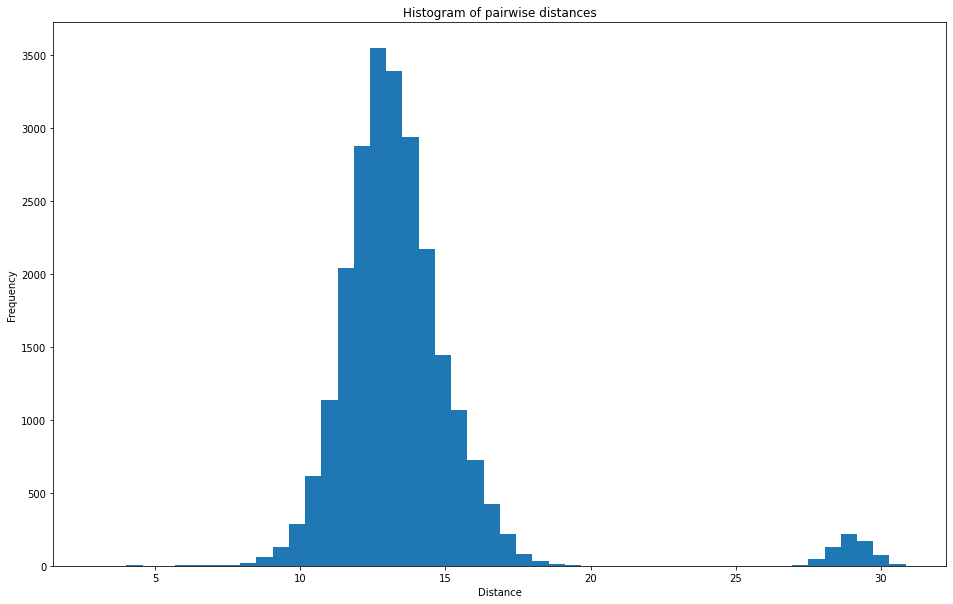

In [15]:
from scipy.spatial.distance import pdist, squareform

# Calculate pairwise distances
pairwise_distances = pdist(X_test_scaled, metric='euclidean')
distance_matrix = squareform(pairwise_distances)

# Plot histogram of distances
plt.figure(figsize=(16, 10))
plt.hist(pairwise_distances, bins=50)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of pairwise distances')
plt.show()

In [16]:
from sklearn.metrics import pairwise_distances
from scipy.stats import pearsonr
import random

def max_sensitivity(X_test, shap_values, r=0.1):
    sensitivities = []
    for i, x in enumerate(X_test):
        # Find all points within a radius r of the current test point x
        neighborhood = X_test[np.linalg.norm(X_test - x, axis=1) < r]
        if len(neighborhood) > 1:
            # Flatten SHAP values for the test point and its neighbors
            shap_values_flat = np.concatenate([shap_values[class_idx][i] for class_idx in range(len(shap_values))])
            neighborhood_flat = [np.concatenate([shap_values[class_idx][j] for class_idx in range(len(shap_values))]) for j in range(len(neighborhood))]
            
            # Calculate pairwise distances between the test point's SHAP values and its neighbors' SHAP values
            distances = pairwise_distances([shap_values_flat], neighborhood_flat)
            max_sensitivity = np.max(distances)  # Find the maximum distance
            sensitivities.append(max_sensitivity)
        else:
            sensitivities.append(np.nan)  # Append NaN if the neighborhood is too small
    mean_max_sensitivity = np.nanmean(sensitivities)  # Compute the mean, ignoring NaNs
    return mean_max_sensitivity

def avg_sensitivity(X_test, shap_values, r=0.1):
    sensitivities = []
    for i, x in enumerate(X_test):
        # Find all points within a radius r of the current test point x
        neighborhood = X_test[np.linalg.norm(X_test - x, axis=1) < r]
        if len(neighborhood) > 1:
            # Flatten SHAP values for the test point and its neighbors
            shap_values_flat = np.concatenate([shap_values[class_idx][i] for class_idx in range(len(shap_values))])
            neighborhood_flat = [np.concatenate([shap_values[class_idx][j] for class_idx in range(len(shap_values))]) for j in range(len(neighborhood))]
            
            # Calculate pairwise distances between the test point's SHAP values and its neighbors' SHAP values
            distances = pairwise_distances([shap_values_flat], neighborhood_flat)
            avg_sensitivity = np.mean(distances)  # Find the average distance
            sensitivities.append(avg_sensitivity)
        else:
            sensitivities.append(np.nan)  # Append NaN if the neighborhood is too small
    mean_avg_sensitivity = np.nanmean(sensitivities)  # Compute the mean, ignoring NaNs
    return mean_avg_sensitivity

def faithfulness(X_train_scaled, X_test, shap_values, model, subset_sizes=[20, 50, 80]):
    random.seed(42)
    np.random.seed(42)
    faithfulness_scores = []
    baseline = np.mean(X_train_scaled, axis=0)
    for i, x in enumerate(X_test):
        shap_sums = []
        y_diffs = []
        for subset_size in subset_sizes:
            # Randomly select a subset of features
            indices = np.random.choice(len(x), subset_size, replace=False)
            x_baseline = np.copy(x)
            x_baseline[indices] = baseline[indices]
            y_diff = model.predict_proba(np.array([x]))[0] - model.predict_proba(np.array([x_baseline]))[0]
            shap_sum = np.sum([shap_values[class_idx][i][indices] for class_idx in range(len(shap_values))])
            shap_sums.append(shap_sum)
            y_diffs.append(y_diff.sum())
        
        if len(shap_sums) > 1 and len(y_diffs) > 1:
            if np.var(shap_sums) != 0 and np.var(y_diffs) != 0:  # Check for variance
                corr, _ = pearsonr(shap_sums, y_diffs)
                faithfulness_scores.append(corr)
            else:
                faithfulness_scores.append(np.nan)  # Append NaN if no variance in data
        else:
            faithfulness_scores.append(np.nan)
    
    mean_faithfulness = np.nanmean(faithfulness_scores)  # Compute the mean, ignoring NaNs
    return mean_faithfulness

def complexity(shap_values):
    complexities = []
    for i in range(len(shap_values[0])):  # Number of test samples
        for class_idx in range(len(shap_values)):  # Number of classes
            P_g = np.abs(shap_values[class_idx][i]) / np.sum(np.abs(shap_values[class_idx][i]))  # Normalize SHAP values
            complexity = -np.sum(P_g * np.log(P_g + 1e-9))  # Calculate entropy
            complexities.append(complexity)
    mean_complexity = np.mean(complexities)
    return mean_complexity

In [17]:
# Compute the metrics
mean_max_sensitivity = max_sensitivity(X_test_scaled, shap_values, r=15)
mean_avg_sensitivity = avg_sensitivity(X_test_scaled, shap_values, r=15)
mean_faithfulness = faithfulness(X_train_scaled, X_test_scaled, shap_values, model1)
mean_complexity = complexity(shap_values)

# Print the results
print("Mean Max Sensitivity:", mean_max_sensitivity)
print("Mean Avg Sensitivity:", mean_avg_sensitivity)
print("Mean Faithfulness:", mean_faithfulness)
print("Mean Complexity:", mean_complexity)

Mean Max Sensitivity: 0.9112298185187295
Mean Avg Sensitivity: 0.6217249755486329
Mean Faithfulness: 0.003944717372080728
Mean Complexity: 4.0215939408931


In [18]:
# Features of interest
features_of_interest = {'q_005', 'q_021', 'q_024', 'q_025', 'q_105', 'q_106', 'q_112', 'q_114'}

# Filter the DataFrame
filtered_df = df_feature_importances[df_feature_importances['Feature'].isin(features_of_interest)]

# Calculate the cumulative sum of 'CumulativeSum' for the filtered features
cumulative_sum_of_interest = filtered_df['CumulativeSum'].sum()

print("Cumulative sum of selected features:", cumulative_sum_of_interest)

Cumulative sum of selected features: 8.259996658402313
